In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import utils
import os
from tqdm import tqdm
mpl.rcParams['figure.dpi'] = 100

datapath = "data/"
figpath = "../manuscript/fig/"
# figpath = "fig/"

# Create dir if it does not exist
if not os.path.isdir(figpath):
    os.mkdir(figpath)

%load_ext autoreload
%autoreload 2

In [2]:
# Read global mean data.
df = pd.read_csv(datapath + "means-europe.csv", skiprows=20)
# Drop self sufficiency; not needed for this notebook
df.drop("suff", axis = 1)

# Drop nans if any
df.dropna(inplace = True)
df.reset_index(inplace = True, drop = True)


# Compute weights according to latitude
lat_weights = np.array(np.cos(2*np.pi*df.lat / 360))
df["lat_weights"] = lat_weights

# Subsample for faster clustering
df_s = utils.subsample_df(df, 0.5)
df_s

,lat,lon,tilt,G,Tamb,Tmod,Tw,E,eff,suff,lat_weights
35,28.0,-15.5,25.0,2127.471000,19.509278,24.297066,35.577182,2047.473002,0.962398,0.971341,0.882948
156,28.5,-14.0,26.0,2270.026463,19.921572,24.654394,35.278485,2188.590247,0.964125,0.987708,0.878817
321,35.0,25.0,28.0,2064.171928,18.840401,24.608421,40.340440,1956.049038,0.947619,0.930326,0.819152
331,35.0,25.5,31.0,2239.008876,18.979949,24.999832,39.772397,2127.926580,0.950388,0.960737,0.819152
336,35.0,32.5,29.0,2093.249872,17.705559,23.805101,40.446050,1983.506919,0.947573,0.937170,0.819152
...,...,...,...,...,...,...,...,...,...,...,...
264942,70.5,29.0,51.0,868.588445,-1.289001,1.114567,15.000324,874.634233,1.006960,0.519559,0.333807
264952,70.5,29.5,50.0,883.443220,-1.943477,0.460058,14.569790,891.404900,1.009012,0.524841,0.333807
264962,70.5,30.0,50.0,890.383971,-0.455793,1.923889,15.323642,896.589079,1.006969,0.528734,0.333807
264972,70.5,30.5,50.0,890.323288,0.947063,3.182910,15.373711,896.555444,1.007000,0.528740,0.333807


# Interpolation of joint importance of $G$ and $T_{scale}$

In [3]:
# Some setup 
var1 = np.array(df_s.G)
var2 = np.array(df_s.Tw)
diam1 = np.std(var1)
diam2 = np.std(var2)
ordered_G_indices = np.argsort(var1)
N = len(df_s)
lat_weights = np.cos(np.pi*np.array(df_s.lat) / 180)

Nclusters = 3

# Number of KMeans trials
N_trials = 100
results_clustering = dict()
best_score = np.inf
thetas = [0, 0.5, 1.0]

for th in thetas:
    data = np.hstack((((1-th)*var1.reshape(-1, 1)/diam1), (th*var2.reshape(-1, 1)/diam2)))
    dim = data.shape[1]
    # Try KMeans several times and keep best
    best_score = np.inf
    for i in tqdm(range(N_trials)):
        index_init = np.argsort(data @ np.array([1,1]))[::(N//Nclusters)+1]

        cl, c, index = utils.KMeans(data, K = Nclusters, Niter = 20, index_init = index_init, 
                                weights = np.array(df_s.lat_weights),  p = 2)
        D_ij = ((data.reshape(-1, 1, dim) -  c.reshape(1, -1, dim))** 2).sum(-1)
        score = D_ij.min(-1).sum()
        if score < best_score:
            best_score = score
            best_c = c

        
    idx_sort = np.argsort(best_c @ np.array([1, 1]))
    c = best_c[idx_sort]
    results_clustering[th] = dict(c = c, ind = index)

100%|██████████| 100/100 [00:01<00:00, 92.44it/s]


Total representatives 378
Total representatives 8
Total representatives 474


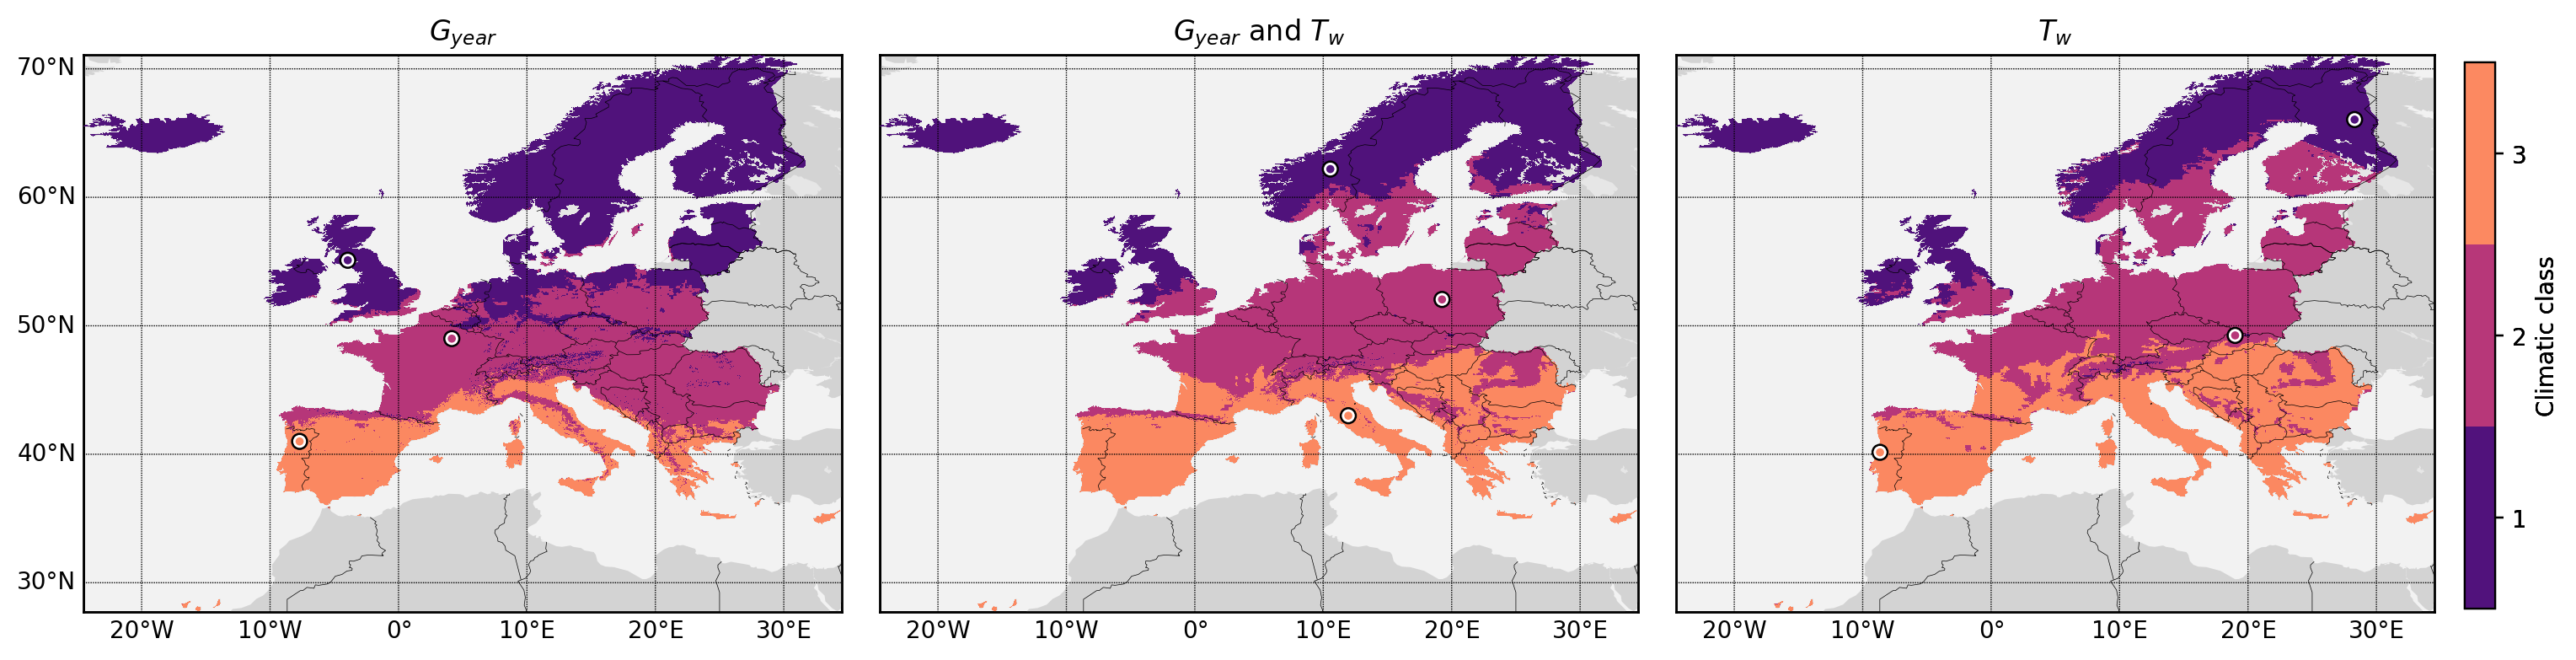

In [4]:
# Theta interpolates between who is most important. Theta = 0 means only G 
# is important, theta = 1 means only Tscale is important.
titles = [r"$G_{year}$", r"$G_{year}$ and $T_w$", r"$T_w$"]

savefig = True

cmap = plt.cm.get_cmap("magma", Nclusters+2)
fig, axs = plt.subplots(1,  3, figsize = (18,6), dpi = 200)
for (i, th) in enumerate(thetas):
    ax = axs[i]
    ax.set_title(titles[i])
    ax.set_rasterization_zorder(1.5)
    # subax = ax.inset_axes([0.05, 0.55, 0.2, 0.2])
    data = np.hstack((((1-th)*np.array(df.G).reshape(-1, 1)/diam1), (th*np.array(df.Tw).reshape(-1, 1)/diam2)))
    c = results_clustering[th]["c"]
    
    cl = ((data.reshape(-1, 1, dim) - c.reshape(1, -1, dim))**2).sum(-1).argmin(axis=1).reshape(-1) 
    
    img, extent = utils.rasterize(df.lat, df.lon, cl)
    label_coords = [True, False, False, True]
    if i> 0:
        label_coords[0] = False
    ax = utils.drawmap(ax, extent[2:]+extent[:2], projection = "cyl", step_grid = 10, 
                       label_coords = label_coords, basemap_res = "l")

    ims = ax.imshow(img, origin = "lower", cmap = cmap, extent = extent, 
            clim = (-1.5, Nclusters+0.5), zorder = 3,
          interpolation = "nearest")
    ind = utils.random_representatives(data, c, 0.001)
    ax.scatter(df.lon[ind], df.lat[ind], c = cmap(np.arange(Nclusters)+1), marker = "o", edgecolor = "k", linewidth = 1, s = 40, zorder = 100)
    ax.scatter(df.lon[ind], df.lat[ind], c = cmap(np.arange(Nclusters)+1), marker = "o", edgecolor = "w", linewidth = 1, s = 20, zorder = 200)  

    

    # Classification bar
    clax = fig.add_axes((0.91,0.23, 0.01, 0.54))
    plt.colorbar(ims, cax = clax)
    clax.set_ylabel("Climatic class")
    clax.set_yticks(np.arange(Nclusters), np.arange(1,Nclusters+1))
    clax.set_ylim([-0.5, Nclusters-0.5])
plt.subplots_adjust(wspace = 0.05)
if savefig: 
   plt.savefig(figpath + f"clustering-europe-theta-Nclusters-{Nclusters}.pdf", bbox_inches = "tight")
plt.show()

             G         Tw
0  1112.132128  26.455740
1  1482.896214  31.005083
2  1939.513111  38.674456
             G         Tw
0  1034.387819  22.281223
1  1345.152393  29.711165
2  1812.655281  36.902716


/tmp/ipykernel_1389466/2458864344.py:20: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data = df_cluster, x = "G", y = "Tw", s = 20,  ax = axs[i], palette = cmap, edgecolor = "white", facecolor = "none", linewidth = 1, zorder = +100)
/tmp/ipykernel_1389466/2458864344.py:21: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data = df_cluster, x = "G", y = "Tw", s = 40,  ax = axs[i], palette = cmap, edgecolor = "black", facecolor = "none", linewidth = 1, zorder = +100)
/tmp/ipykernel_1389466/2458864344.py:20: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data = df_cluster, x = "G", y = "Tw", s = 20,  ax = axs[i], palette = cmap, edgecolor = "white", facecolor = "none", linewidth = 1, zorder = +100)
/tmp/ipykernel_1389466/2458864344.py:21: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data = df_clust

             G         Tw
0   946.511227  21.341190
1  1429.765522  28.923842
2  1592.687862  36.585186


/tmp/ipykernel_1389466/2458864344.py:20: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data = df_cluster, x = "G", y = "Tw", s = 20,  ax = axs[i], palette = cmap, edgecolor = "white", facecolor = "none", linewidth = 1, zorder = +100)
/tmp/ipykernel_1389466/2458864344.py:21: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data = df_cluster, x = "G", y = "Tw", s = 40,  ax = axs[i], palette = cmap, edgecolor = "black", facecolor = "none", linewidth = 1, zorder = +100)


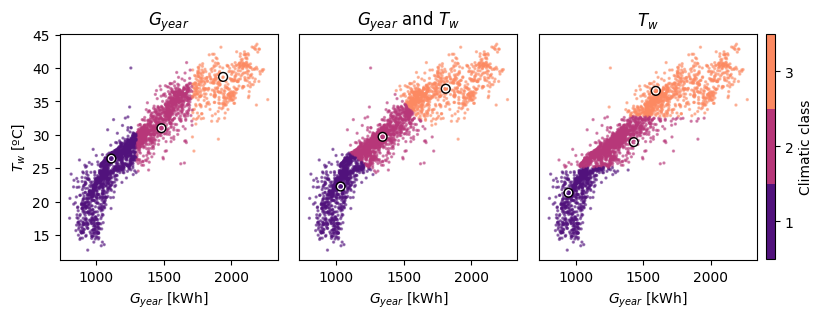

In [5]:
fig, axs = plt.subplots(figsize = (9,3), dpi = 100, ncols = 3)
# Plot for P and eff
labels = dict(G = r"$G_{year}$ [kWh]", Tw = r"$T_w$ [ºC]", P = r"$E_{year}$ [kWh]", eff = r"$\eta$ [-]")

np.random.seed(0)
for (i, th) in enumerate(thetas):
    ax = axs[i]
    data = np.hstack((((1-th)*var1.reshape(-1, 1)/diam1), (th*var2.reshape(-1, 1)/diam2)))

    c = results_clustering[th]["c"]
    cl = ((data.reshape(-1, 1, dim) - c.reshape(1, -1, dim))**2).sum(-1).argmin(axis=1).reshape(-1) 

    axs[i].scatter(df_s["G"], df_s["Tw"], s = 2, c = [plt.cm.magma((ci+1)/4) for ci in cl], 
                   alpha = 0.5)
    axs[i].set_xlabel(labels["G"])
    df_cluster = pd.DataFrame(np.array(df_s)[results_clustering[th]["ind"],:], columns = df_s.columns)
    print(df_cluster[["G", "Tw"]])


    sns.scatterplot(data = df_cluster, x = "G", y = "Tw", s = 20,  ax = axs[i], palette = cmap, edgecolor = "white", facecolor = "none", linewidth = 1, zorder = +100)
    sns.scatterplot(data = df_cluster, x = "G", y = "Tw", s = 40,  ax = axs[i], palette = cmap, edgecolor = "black", facecolor = "none", linewidth = 1, zorder = +100)
  
    offsetx = 300

    if i > 0:
        axs[i].set_ylabel("")
        axs[i].set_yticks([])
    else:
        axs[i].set_ylabel(labels["Tw"])
    ax.set_title(titles[i])
    ax.set_rasterization_zorder(1.5)      

# Classification bar
clax = fig.add_axes((0.91,0.13, 0.01, 0.75))
plt.colorbar(ims, cax = clax)
clax.set_ylabel("Climatic class")
clax.set_yticks(np.arange(Nclusters), np.arange(1,Nclusters+1))
clax.set_ylim([-0.5, 2.5])

plt.subplots_adjust(wspace = 0.1)
if savefig:
    plt.savefig(figpath+"GT-scatter-europe.pdf", bbox_inches = "tight")
plt.show()